## Revenue Modelling

### 0 - Begin Spark and read in data

In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "3g")
    .config("spark.driver.memory", "3g")
    .getOrCreate()
)

24/10/02 01:01:09 WARN Utils: Your hostname, MacBook.local resolves to a loopback address: 127.0.0.1; using 192.168.0.6 instead (on interface en0)
24/10/02 01:01:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/02 01:01:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
revenue_df = spark.read.parquet('../data/curated/revenue.parquet')
revenue_df.show(20, truncate = False)

+------------+--------------+-------------------------+--------------------------------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+------------------------+----------------------------------+----------------------------------+-----------+------------------+-----------------------------+--------------------+-----------------------+-------------------------+------------------+
|merchant_abn|order_datetime|merchant_name            |description                                       |revenue_band|take_rate|industry_segment|revenue           |male_count|female_count|undisclosed_count|num_trans|num_postcodes|num_unique_customers|sum_customer_mean_income|average_consumer_fraud_probability|average_merchant_fraud_probability|fraud_count|mean_trans_val    |expected_customer_mean_income|first_order_datetime|days_since_first_record|days_since_first_record_2|cumulative_revenue|
+-

### 1 - Create model for ABN = 10023283211

#### 1.1 - Set up the dataframes

In [44]:
# Take single ABN for trial
merchant_abn = 10023283211
merchant_df = revenue_df.filter(revenue_df['merchant_abn'] == merchant_abn)

print("Number of entries =", merchant_df.count())
merchant_df.show(20, truncate = False)

Number of entries = 604
+------------+--------------+-------------+---------------------------------------------------------------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+------------------------+----------------------------------+----------------------------------+-----------+------------------+-----------------------------+--------------------+-----------------------+-------------------------+------------------+
|merchant_abn|order_datetime|merchant_name|description                                                                      |revenue_band|take_rate|industry_segment|revenue           |male_count|female_count|undisclosed_count|num_trans|num_postcodes|num_unique_customers|sum_customer_mean_income|average_consumer_fraud_probability|average_merchant_fraud_probability|fraud_count|mean_trans_val    |expected_customer_mean_income|first_order_datetime|days_since

In [45]:
# Split into training and test df
split_point = int(merchant_df.count() * 0.8)

train_data = merchant_df.limit(split_point)
test_data = merchant_df.subtract(train_data).orderBy('order_datetime')

#### 1.2 - LASSO Linear Regression

In [50]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Define predictors
feature_columns = ['days_since_first_record',
                   'days_since_first_record_2',
                   'num_trans',
                   #'num_postcodes', 
                   #'num_unique_customers',
                   #'average_consumer_fraud_probability', 
                   #'average_merchant_fraud_probability', 
                   'fraud_count', 
                   #'expected_customer_mean_income',
                   ]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')

# Linear Regression Model
lasso = LinearRegression(featuresCol = 'features', 
                         labelCol = 'revenue',
                         maxIter = 50,
                         elasticNetParam = 1.0, 
                         regParam = 1.0,
                         standardization = True,
                         loss = 'squaredError')

# Create pipeline with assembler and Linear Regression
pipeline = Pipeline(stages = [assembler, lasso])

# Fit to training data
lasso_model = pipeline.fit(train_data)

# Predict on training and test data
train_pred = lasso_model.transform(train_data)
test_pred = lasso_model.transform(test_data)

# Get RMSE
evaluator = RegressionEvaluator(labelCol = 'revenue', predictionCol = 'prediction', metricName = 'rmse')

# Train RMSE
print('Training RMSE =', evaluator.evaluate(train_pred))
# Test RMSE
print('Testing RMSE =', evaluator.evaluate(test_pred))


Training RMSE = 305.10122170937245
Testing RMSE = 306.47238546824303


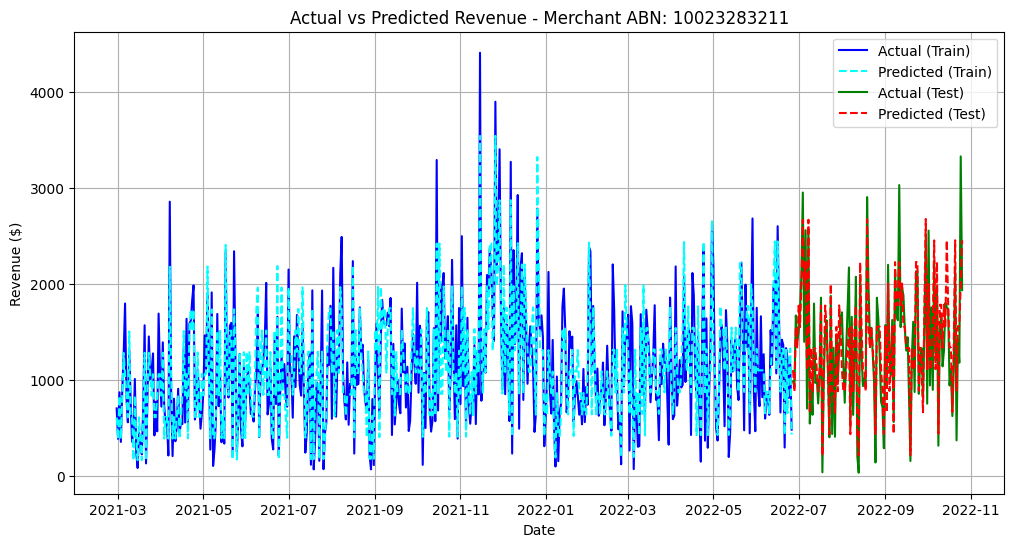

In [47]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
train_pd = train_pred.select('order_datetime', 'revenue', 'prediction').toPandas()
test_pd = test_pred.select('order_datetime', 'revenue', 'prediction').toPandas()

# Plot actual and predicted cumulative_revenue
plt.figure(figsize = (12, 6))

# True training values
plt.plot(train_pd['order_datetime'], train_pd['revenue'], label = 'Actual (Train)', color = 'blue')
# Predicted training values
plt.plot(train_pd['order_datetime'], train_pd['prediction'], label = 'Predicted (Train)', color = 'cyan', linestyle = '--')

# True testing values
plt.plot(test_pd['order_datetime'], test_pd['revenue'], label = 'Actual (Test)', color = 'green')
# Predicted testing values
plt.plot(test_pd['order_datetime'], test_pd['prediction'], label = 'Predicted (Test)', color = 'red', linestyle = '--')

plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.title('Actual vs Predicted Revenue - Merchant ABN: 10023283211')
plt.legend()
plt.grid(True)
plt.show()


#### 1.3 - Random Forest Regression (For Comparison)

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Define predictors
feature_columns = ['days_since_first_record',
                   'days_since_first_record_2',
                   'num_trans',
                   'num_postcodes', 
                   'num_unique_customers',
                   'average_consumer_fraud_probability', 
                   'average_merchant_fraud_probability', 
                   'fraud_count', 
                   'expected_customer_mean_income',
                   ]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
# RFR
rf = RandomForestRegressor(numTrees = 100, maxDepth = 5, featuresCol = 'features', labelCol = 'revenue')
# Create pipeline with assembler and RF
pipeline = Pipeline(stages = [assembler, rf])

# Fit to training data
rf_model = pipeline.fit(train_data)

# Predict on training and test data
train_pred = rf_model.transform(train_data)
test_pred = rf_model.transform(test_data)

# Get RMSE
evaluator = RegressionEvaluator(labelCol = 'revenue', predictionCol = 'prediction', metricName = 'rmse')
# Train RMSE
print('Training RMSE =', evaluator.evaluate(train_pred))
# Test RMSE
print('Testing RMSE =', evaluator.evaluate(test_pred))

Training RMSE = 273.8452968525768
Testing RMSE = 327.01291888975993


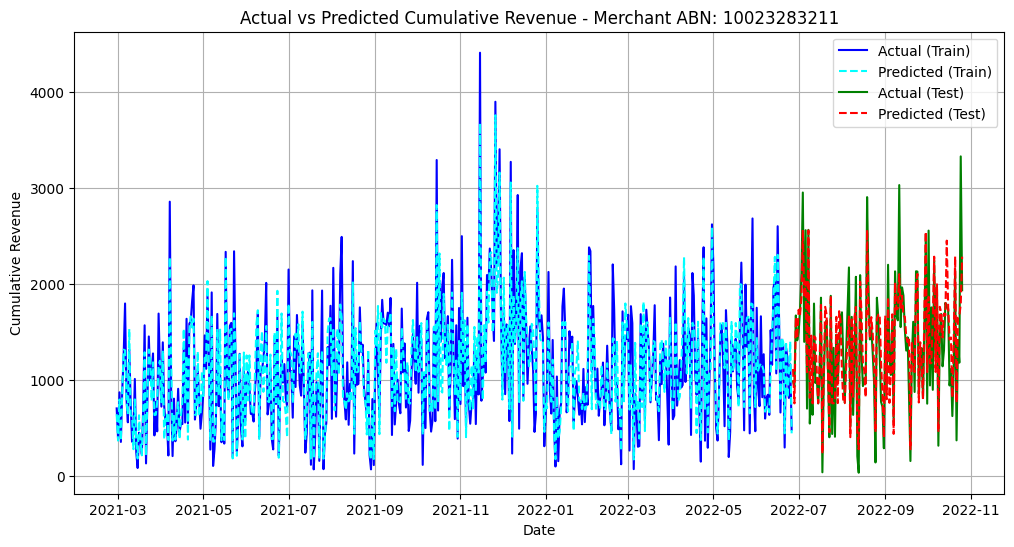

In [8]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
train_pd = train_pred.select('order_datetime', 'revenue', 'prediction').toPandas()
test_pd = test_pred.select('order_datetime', 'revenue', 'prediction').toPandas()

# Plot actual and predicted cumulative_revenue
plt.figure(figsize = (12, 6))

# True training values
plt.plot(train_pd['order_datetime'], train_pd['revenue'], label = 'Actual (Train)', color = 'blue')
# Predicted training values
plt.plot(train_pd['order_datetime'], train_pd['prediction'], label = 'Predicted (Train)', color = 'cyan', linestyle = '--')

# True testing values
plt.plot(test_pd['order_datetime'], test_pd['revenue'], label = 'Actual (Test)', color = 'green')
# Predicted testing values
plt.plot(test_pd['order_datetime'], test_pd['prediction'], label = 'Predicted (Test)', color = 'red', linestyle = '--')

plt.xlabel('Date')
plt.ylabel('Cumulative Revenue')
plt.title('Actual vs Predicted Cumulative Revenue - Merchant ABN: 10023283211')
plt.legend()
plt.grid(True)
plt.show()


#### 1.4 - SARIMAX

In [18]:
import pandas as pd

# Make predictions
train_pred = lasso_model.transform(train_data)
test_pred = lasso_model.transform(test_data)

# Select relevant columns and convert to Pandas DataFrame
train_pred_pd = train_pred.select('revenue', 'prediction', 'order_datetime').toPandas()
test_pred_pd = test_pred.select('revenue', 'prediction', 'order_datetime').toPandas()

# Combine predictions into a single DataFrame
merchant_pd = pd.concat([train_pred_pd, test_pred_pd])

merchant_pd['order_datetime'] = pd.to_datetime(merchant_pd['order_datetime'])
merchant_pd.set_index('order_datetime', inplace = True)

# Reindex to fill missing dates
full_range = pd.date_range(start = merchant_pd.index.min(), end = merchant_pd.index.max(), freq = 'D')
merchant_pd = merchant_pd.reindex(full_range).fillna(method = 'ffill')  # Forward fill missing values

/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_48134/3338324191.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merchant_pd = merchant_pd.reindex(full_range).fillna(method = 'ffill')  # Forward fill missing values


{'fopt': np.float64(7.5927879788665), 'gopt': array([-6.44303277e-05,  1.35349509e-06, -8.23494162e-05,  2.57571742e-09,
        1.92734718e-07]), 'fcalls': 348, 'warnflag': 0, 'converged': True, 'iterations': 51}


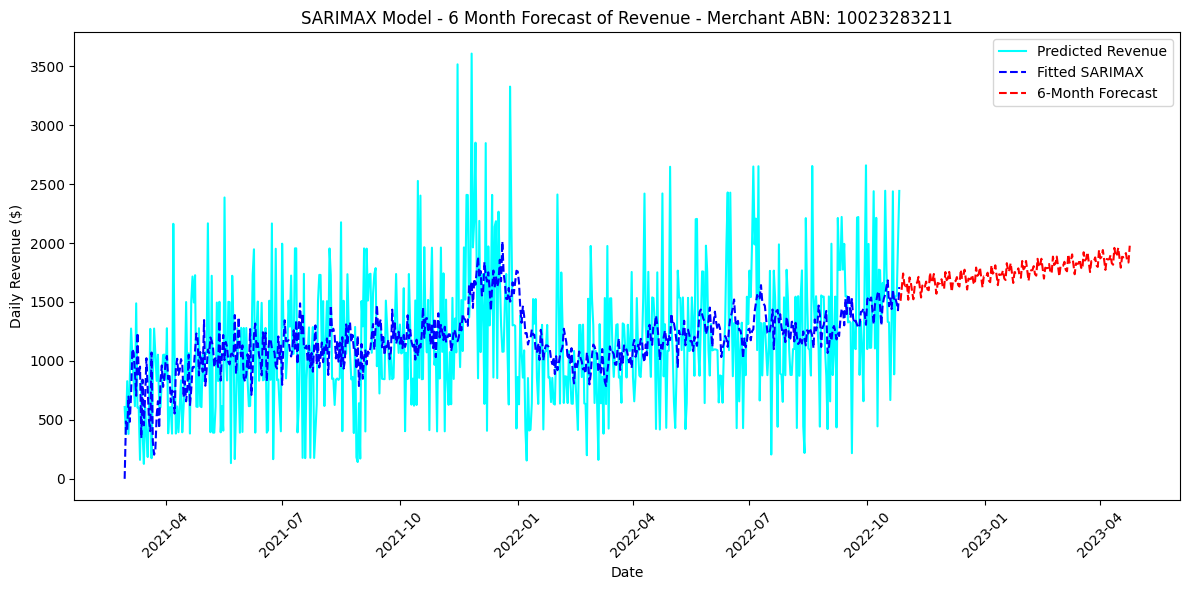

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

time_series_data = merchant_pd['prediction']

model = SARIMAX(time_series_data, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12), freq = "D")
fitted_model = model.fit(maxiter = 500, disp = False)
print(fitted_model.mle_retvals)

in_sample_predictions = fitted_model.fittedvalues

forecast_steps = 180
forecast = fitted_model.forecast(steps = forecast_steps)

last_date = time_series_data.index[-1]
forecast_index = pd.date_range(start = last_date + pd.DateOffset(days = 1), periods = forecast_steps, freq = 'D')
forecast_series = pd.Series(forecast, index = forecast_index)

plt.figure(figsize = (12, 6))
plt.plot(time_series_data.index, time_series_data, label = 'Predicted Revenue', color = 'cyan')

plt.plot(in_sample_predictions.index, in_sample_predictions, label = 'Fitted SARIMAX', color = 'blue', linestyle = '--')
plt.plot(forecast_series.index, forecast_series, label = '6-Month Forecast', color = 'red', linestyle = '--')

plt.title('SARIMAX Model - 6 Month Forecast of Revenue - Merchant ABN: 10023283211')
plt.xlabel('Date')
plt.ylabel('Daily Revenue ($)')
plt.legend()

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

{'fopt': np.float64(7.749917591608642), 'gopt': array([ 4.74277506e-05, -2.23820962e-08,  2.41406006e-05,  1.61026747e-07,
        6.19948539e-08]), 'fcalls': 360, 'warnflag': 0, 'converged': True, 'iterations': 45}


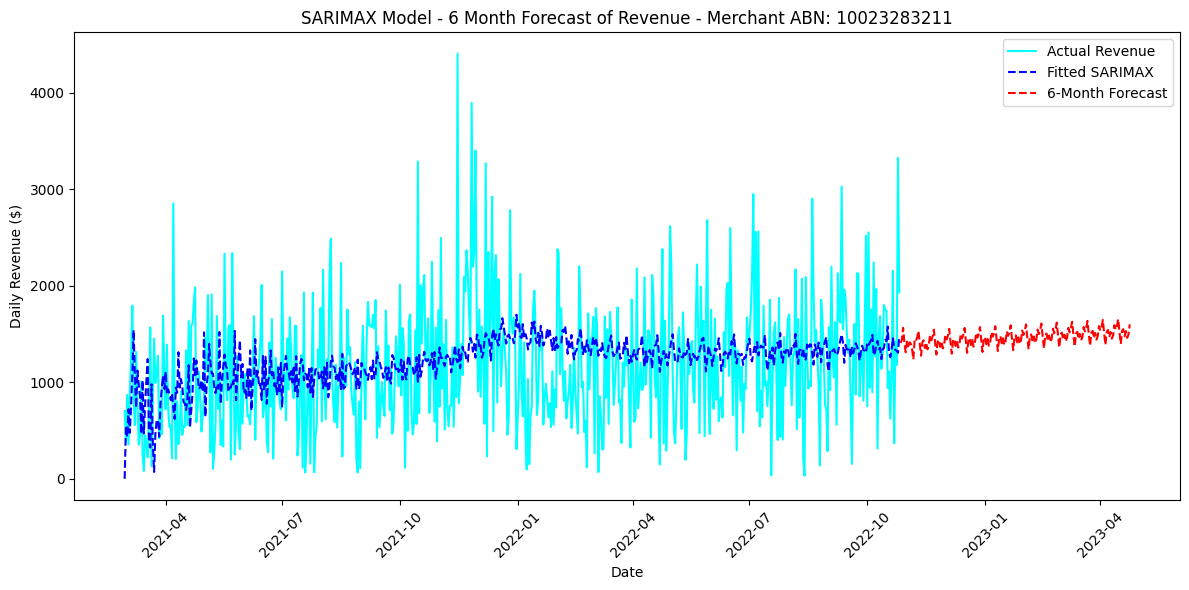

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

time_series_data = merchant_pd['revenue']

model = SARIMAX(time_series_data, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12), freq = "D")
fitted_model = model.fit(maxiter = 500, disp = False)
print(fitted_model.mle_retvals)

in_sample_predictions = fitted_model.fittedvalues

forecast_steps = 180
forecast = fitted_model.forecast(steps = forecast_steps)

last_date = time_series_data.index[-1]
forecast_index = pd.date_range(start = last_date + pd.DateOffset(days = 1), periods = forecast_steps, freq = 'D')
forecast_series = pd.Series(forecast, index = forecast_index)

plt.figure(figsize = (12, 6))
plt.plot(time_series_data.index, time_series_data, label = 'Actual Revenue', color = 'cyan')

plt.plot(in_sample_predictions.index, in_sample_predictions, label = 'Fitted SARIMAX', color = 'blue', linestyle = '--')
plt.plot(forecast_series.index, forecast_series, label = '6-Month Forecast', color = 'red', linestyle = '--')

plt.title('SARIMAX Model - 6 Month Forecast of Revenue - Merchant ABN: 10023283211')
plt.xlabel('Date')
plt.ylabel('Daily Revenue ($)')
plt.legend()

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()